# Experimentação de modelos

## Modelos
- Prophet
- sktime
- timeGPT
- PMDArima
- Ensemble Methods: XGBoost, LightGBM, RandomForest
- MAs
- LSTMs

## Métricas
- MAPE

## Dependências


In [33]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sktime.split import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.arima import ARIMA
from sktime.utils.plotting import plot_series
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

## Variáveis globais

In [12]:
PATH = '../data/historico_acoes_b3.csv'
TICKER = 'BBAS3.SA'

## Leitura dos dados

In [13]:
df = pd.read_csv(PATH)
df = df[df.Ticker == TICKER][['Date', 'Adj Close']]
df.index = pd.to_datetime(df.Date)
df = df.drop(columns=['Date'])

df = df.asfreq('B')  # 'B' para dias úteis
df['Adj Close'] = df['Adj Close'].fillna(method='ffill')  # Preenche valores ausentes com o último valor conhecido

display(df.head())

C:\Users\ubfil\AppData\Local\Temp\ipykernel_9456\518718327.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Adj Close'] = df['Adj Close'].fillna(method='ffill')  # Preenche valores ausentes com o último valor conhecido


,Adj Close
Date,
2000-01-03 00:00:00+00:00,0.504046
2000-01-04 00:00:00+00:00,0.480073
2000-01-05 00:00:00+00:00,0.484991
2000-01-06 00:00:00+00:00,0.491752
2000-01-07 00:00:00+00:00,0.480688


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Adj Close'>)

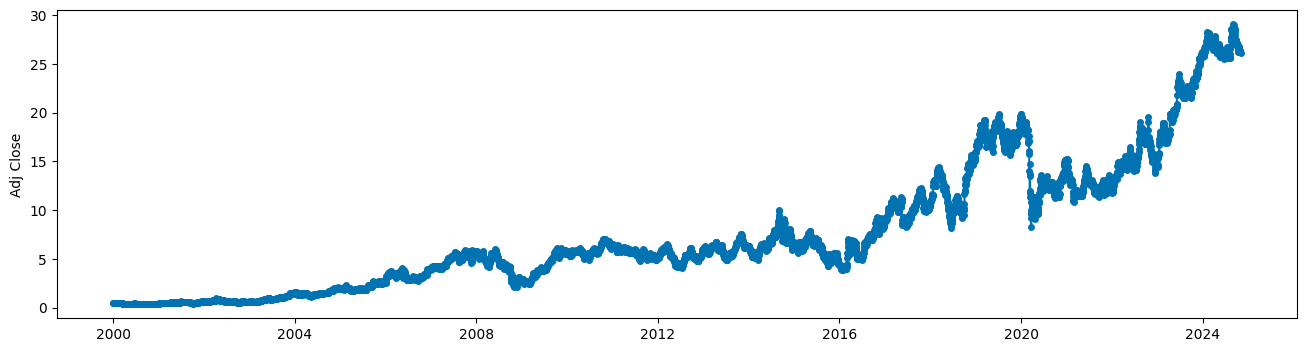

In [14]:
plot_series(df)

## ARIMA

In [15]:
y_train, y_test = temporal_train_test_split(df['Adj Close'], test_size=365)

In [28]:
class SKTimeForecaster:
    """ Classe com métodos de forecasting que podem ser utilizados para qualquer modelo do sktime """
    
    def __init__(self):
        pass
    
    def evaluate_forecast(self, y, y_pred):
        mae = mean_absolute_error(y, y_pred)
        mse = mean_squared_error(y, y_pred)
        mape = mean_absolute_percentage_error(y, y_pred)
        return {'mae': mae, 'mse': mse, 'mape': mape}

    def train_model(self, y_train, model, evaluate=False, horizon=365, y_test=None):
        fh = ForecastingHorizon(np.arange(1, horizon + 1), is_relative=True)

        model.fit(y_train)
        y_pred = model.predict(fh)
        
        if evaluate:
            print(self.evaluate_forecast(y_test, y_pred))
        
        return y_pred

### Treinamento e validação do modelo

{'mae': 3.7547181609819678, 'mse': 18.883555175451338, 'mape': 0.14180588950280548}


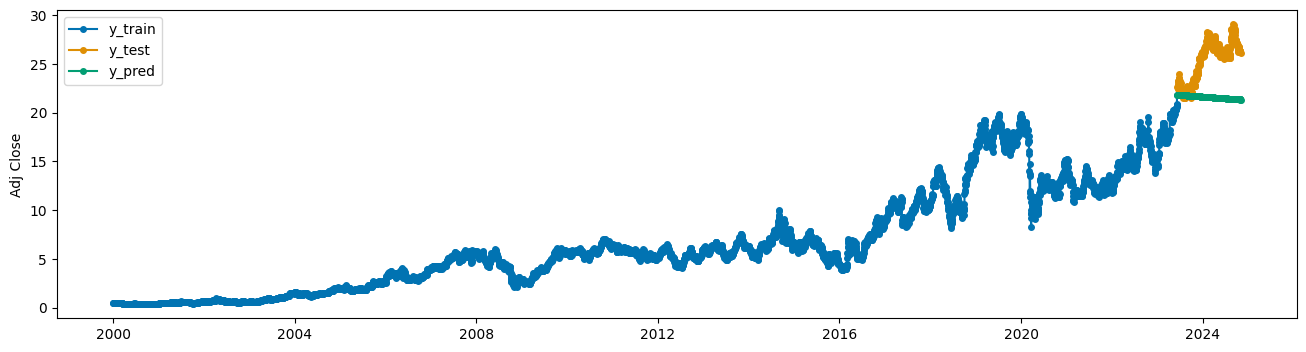

In [34]:
model = ARIMA()

y_test_pred = SKTimeForecaster().train_model(y_train, model, evaluate=True, y_test=y_test)

plot_series(y_train, y_test, y_test_pred, labels=['y_train', 'y_test', 'y_pred'])
plt.show()

### Treinamento com dados completos

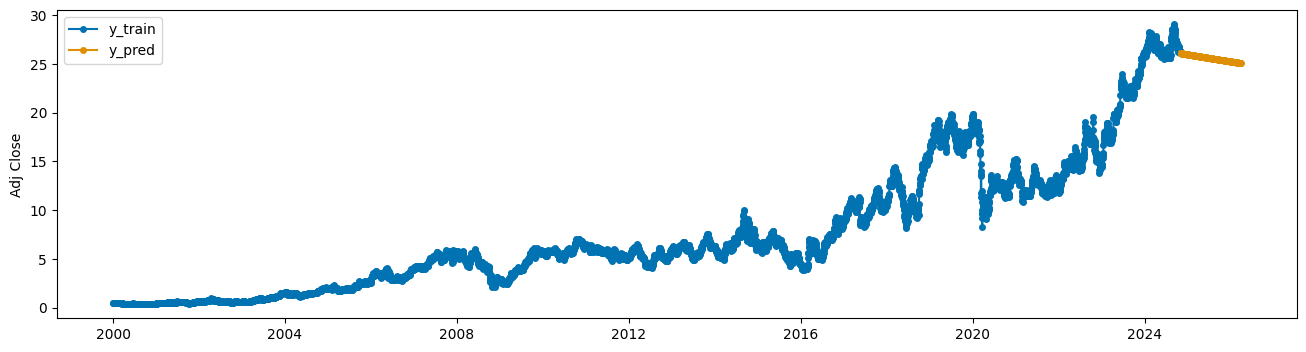

In [38]:
model = ARIMA()

y_pred = SKTimeForecaster().train_model(df['Adj Close'], model, horizon=365)

plot_series(df['Adj Close'], y_pred, labels=['y_train', 'y_pred'])
plt.show()

### Auto-ARIMA

{'mae': 2.8982215612857503, 'mse': 11.402915459271586, 'mape': 0.10937406351934002}


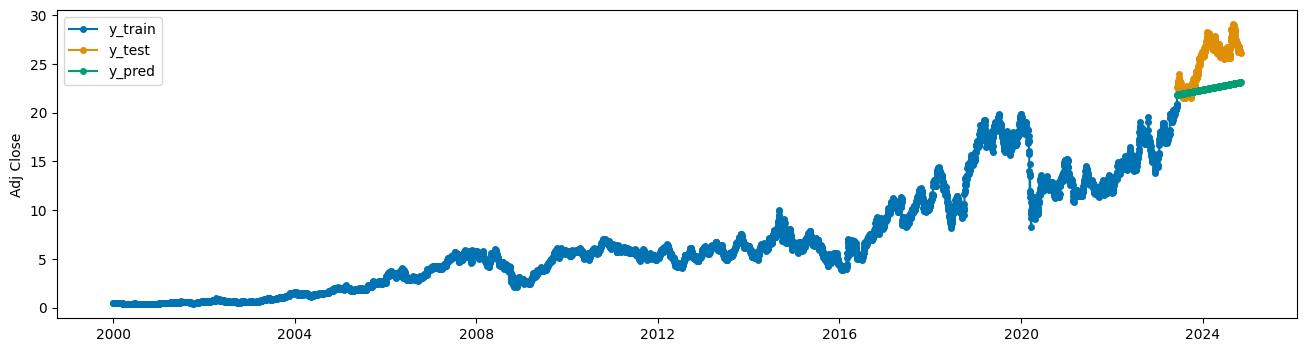

In [39]:
model = AutoARIMA()

y_test_pred = SKTimeForecaster().train_model(y_train, model, evaluate=True, y_test=y_test)

plot_series(y_train, y_test, y_test_pred, labels=['y_train', 'y_test', 'y_pred'])
plt.show()

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Adj Close'>)

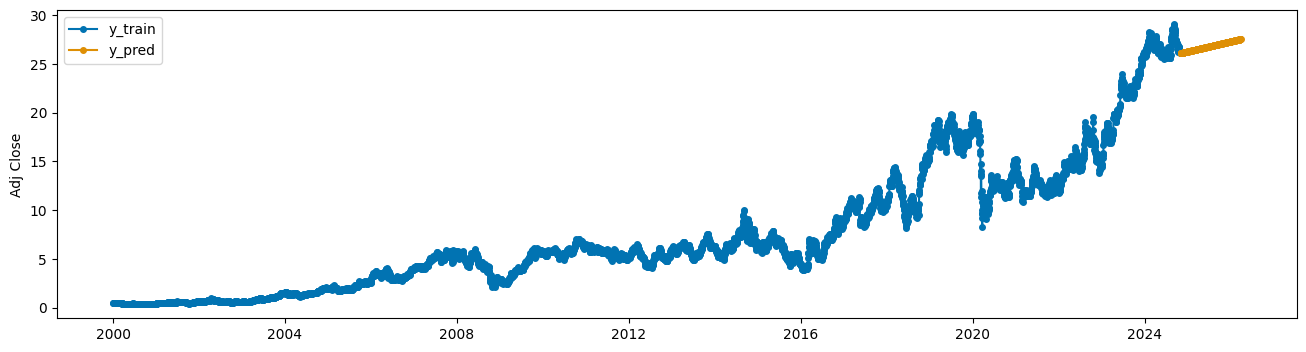

In [40]:
model = AutoARIMA()
 
y_pred = SKTimeForecaster().train_model(df['Adj Close'], model, horizon=365)

plot_series(df['Adj Close'], y_pred, labels=['y_train', 'y_pred'])

## Prophet